In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor

np.random.seed(0)

In [2]:
os.getcwd()
train = pd.read_csv('C:\\Users\\chris\\Desktop\\210\\W210-Capstone\\data\\training.csv')

In [3]:
unemp = train[train['INDICATOR'] == "Unemployment"]
rgdp = train[train['INDICATOR'] == "RealGDP"]
cpce = train[train['INDICATOR'] == "Core PCE"]
ccpi = train[train['INDICATOR'] == "Core CPI"]
ngnp = train[train['INDICATOR'] == "NominalGNP"]
rgnp = train[train['INDICATOR'] == "RealGNP"]

In [4]:
np.random.seed(0)
def model_setup(df):
    
    rand = df.sample(frac = 1)
    #80/20 split
    nrow = len(rand)
    train_prop = int(np.round(nrow*0.8))
    train = rand[:train_prop]
    val = rand[train_prop:]
    
    train = train[["FORECASTER ID", "MAX", "pred_average", "pred_var", "HIT", "ACTUAL_CONF", "actual"]]
    val = val[["FORECASTER ID", "MAX", "pred_average", "pred_var", "HIT", "ACTUAL_CONF", "actual"]]
    
    return train.dropna(), val.dropna()

In [38]:
def run_model(df, variable_name, model, plot=True):
    
    """model can be "LM" or "RF" for linear model or random forest"""
    
    train, val = model_setup(df)
    X_train, Y_train = train[["FORECASTER ID", "MAX", "pred_average", "pred_var", "HIT", "ACTUAL_CONF"]], train["actual"].tolist()
    X_val, Y_val = val[["FORECASTER ID", "MAX", "pred_average", "pred_var", "HIT", "ACTUAL_CONF"]], val["actual"].tolist()
    
    if model == "LM":
        lr = LinearRegression()
        fitted = lr.fit(X_train, Y_train)
        preds = fitted.predict(X_val)
        preds = preds.flatten()
        
    elif model == "RF":
        rf = RandomForestRegressor()
        fitted = rf.fit(X_train, Y_train)

        preds = []
        for i in range(len(Y_val)):
            row = X_val.iloc[[i]].values.tolist()
            pred = rf.predict(row)
            pred = pred.flatten()[0]
            preds.append(pred)
            
    else:
        print("Please select a different model.")
        return
    
    diffs = np.subtract(Y_val, preds)

    r2_pred = np.corrcoef(Y_val, preds)[0][1]
    r2_actual = np.corrcoef(Y_val, np.array(X_val['pred_average'].tolist()))[0][1]
    
    rmse_pred = np.sqrt(mean_squared_error(Y_val, preds))
    rmse_actual = np.sqrt(mean_squared_error(Y_val, np.array(X_val['pred_average'].tolist())))
    
    if plot == True:
        print("Differences in actual vs. model prediction (" + variable_name + ")")
        print("Mean: " + str(np.mean(diffs)))
        print("Median: " + str(np.median(diffs)))
        print("Max: " + str(max(diffs)))
        print("Min: " + str(min(diffs)))
        print("Correlation Coef: " + str(r2_pred))
        print("RMSE: " + str(rmse_pred))

        plt.hist(diffs)
        plt.title("Actual minus Model Prediction (" + variable_name + ")")
        plt.show()

        actual_diffs = np.subtract(Y_val, np.array(X_val['pred_average'].tolist()))
        print("Differences in actual vs. forecaster average prediction (" + variable_name + ")")
        print("Mean: " + str(np.mean(actual_diffs)))
        print("Median: " + str(np.median(actual_diffs)))
        print("Max: " + str(max(actual_diffs)))
        print("Min: " + str(min(actual_diffs)))
        print("Correlation Coef: " + str(r2_pred))
        print("RMSE: " + str(rmse_actual))

        plt.hist(actual_diffs)
        plt.title("Actual Rate minus Forecaster Average Prediction (" + variable_name + ")")
        plt.show()
        
    else:
        return rmse_pred, rmse_actual, r2_pred, r2_actual

In [39]:
def evaluate(model):
    rmse1s = []
    rmse2s = []
    r21s = []
    r22s = []
    for i in [unemp, rgdp, cpce, ccpi, ngnp, rgnp]:
        rmse1, rmse2, r21, r22 = run_model(i, "name", model, plot=False)
        rmse1s.append(rmse1)
        rmse2s.append(rmse2)
        r21s.append(r21)
        r22s.append(r22)
        
    rmse_diff = np.mean(np.subtract(rmse2s,rmse1s))
    r2_diff = np.mean(np.subtract(r21s, r22s))
    
    print("We decrease RMSE by " + str(rmse_diff))
    print("We increase R-squared by " + str(r2_diff))

# Linear Regression

### Unemployment

Differences in actual vs. model prediction (Unemployment)
Mean: -0.028571810847161212
Median: 0.01379088598331002
Max: 3.1815364661507877
Min: -1.8055025582600583
Correlation Coef: 0.9466896563333372
RMSE: 0.5987403359243924


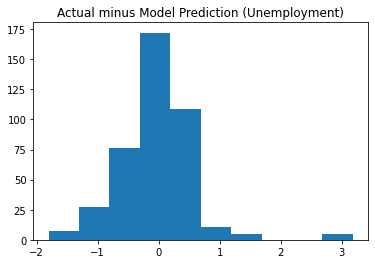

Differences in actual vs. forecaster average prediction (Unemployment)
Mean: -0.5826287842091868
Median: -0.4729166666666704
Max: 2.187499999999999
Min: -2.69166666666667
Correlation Coef: 0.9466896563333372
RMSE: 0.934285665132064


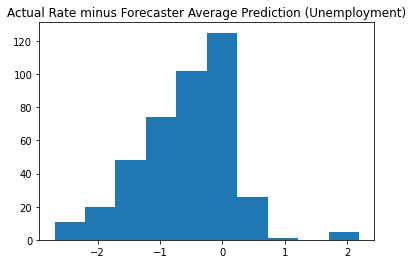

In [40]:
run_model(unemp, "Unemployment", "LM", plot = True)

### Real GDP

Differences in actual vs. model prediction (Real GDP)
Mean: -0.0050856868614993795
Median: -0.057196596120210996
Max: 3.503695972249093
Min: -5.3705190359568356
Correlation Coef: 0.5520689173702364
RMSE: 1.1448399552852484


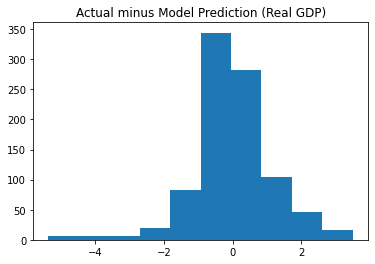

Differences in actual vs. forecaster average prediction (Real GDP)
Mean: -0.05443257765956367
Median: -0.05077499999999979
Max: 3.9472199999999997
Min: -5.136760000000001
Correlation Coef: 0.5520689173702364
RMSE: 1.1874128223543128


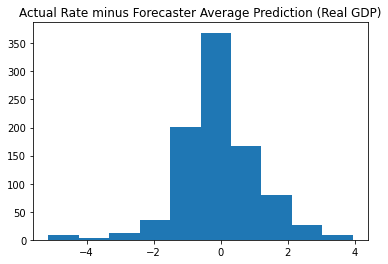

In [41]:
run_model(rgdp, "Real GDP", "LM", plot=True)

### Core PCE

Differences in actual vs. model prediction (Core PCE)
Mean: -0.013797277809919323
Median: -0.05506844742357897
Max: 0.7510801271914447
Min: -0.775789907854749
Correlation Coef: 0.4243862513710222
RMSE: 0.28639461384962256


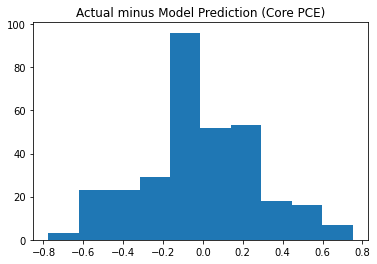

Differences in actual vs. forecaster average prediction (Core PCE)
Mean: -0.18908447486226324
Median: -0.19157529522722994
Max: 1.23175704965729
Min: -1.976400844116175
Correlation Coef: 0.4243862513710222
RMSE: 0.503570862881368


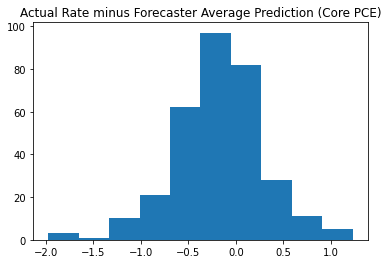

In [42]:
run_model(cpce, "Core PCE", "LM", plot=True)

### Core CPI

Differences in actual vs. model prediction (Core CPI)
Mean: 0.05438760135536903
Median: 0.10567625125419267
Max: 0.7850412275189944
Min: -1.2148740333644619
Correlation Coef: 0.38708373588068545
RMSE: 0.3513953722974833


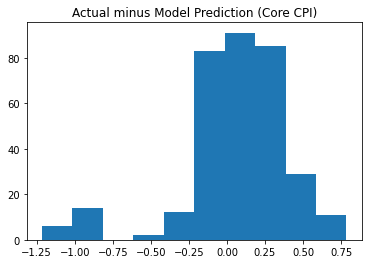

Differences in actual vs. forecaster average prediction (Core CPI)
Mean: -0.04727138228202682
Median: -0.050998075821450106
Max: 1.65022285064397
Min: -1.7044274735366662
Correlation Coef: 0.38708373588068545
RMSE: 0.5051254023141022


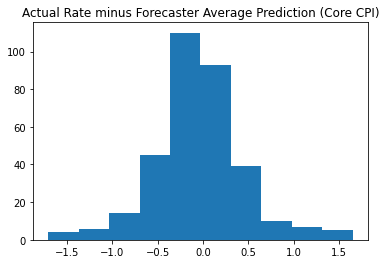

In [43]:
run_model(ccpi, "Core CPI", "LM", plot=True)

### Nominal GNP

Differences in actual vs. model prediction (Nominal GNP)
Mean: 0.0049275525129661955
Median: 0.17972484093428065
Max: 3.8977146885022513
Min: -4.461467743626955
Correlation Coef: 0.7167821317549105
RMSE: 1.4196926646980168


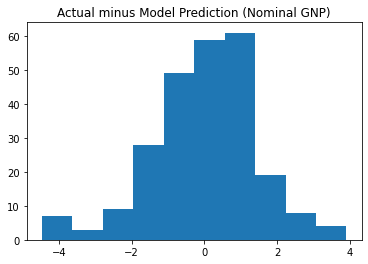

Differences in actual vs. forecaster average prediction (Nominal GNP)
Mean: 1.1611098540906721
Median: 0.8078699999999994
Max: 7.633089999999999
Min: -4.61285
Correlation Coef: 0.7167821317549105
RMSE: 2.3126747758126314


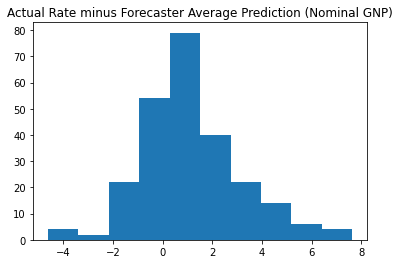

In [44]:
run_model(ngnp, "Nominal GNP", "LM", plot=True)

### Real GNP

Differences in actual vs. model prediction (Real GNP)
Mean: -0.13903147912485478
Median: 0.18956436706357455
Max: 5.1455909496617735
Min: -7.022807907549741
Correlation Coef: 0.7689683674478865
RMSE: 1.5387371092109676


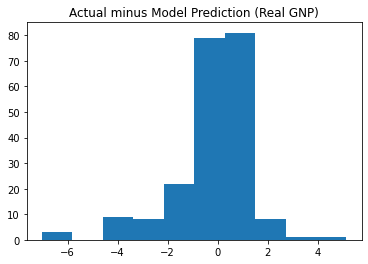

Differences in actual vs. forecaster average prediction (Real GNP)
Mean: 0.6416884055669716
Median: 0.8447200000000001
Max: 6.50071
Min: -5.73796
Correlation Coef: 0.7689683674478865
RMSE: 1.6971846677679487


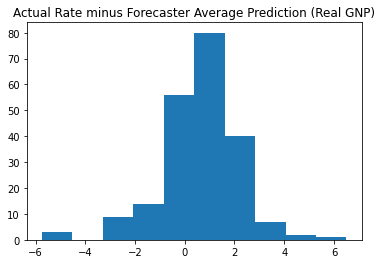

In [45]:
run_model(rgnp, "Real GNP", "LM", plot=True)

## Linear Regression Evaluation

In [46]:
evaluate("LM")

We decrease RMSE by 0.29029289284914767
We increase R-squared by 0.05741491198428569


# Random Forest Regression

### Unemployment

Differences in actual vs. model prediction (Unemployment)
Mean: 0.012337036414567217
Median: -1.2434497875801753e-14
Max: 3.200214285714287
Min: -1.5644166666666743
Correlation Coef: 0.9623234648599867
RMSE: 0.5183335533889085


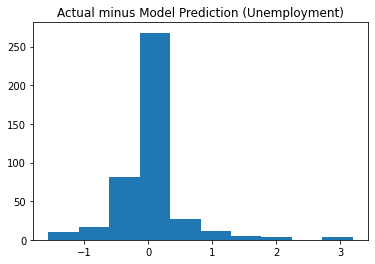

Differences in actual vs. forecaster average prediction (Unemployment)
Mean: -0.561682784986702
Median: -0.44166666666667
Max: 2.57083333333333
Min: -2.77553333333333
Correlation Coef: 0.9623234648599867
RMSE: 0.9087851133858024


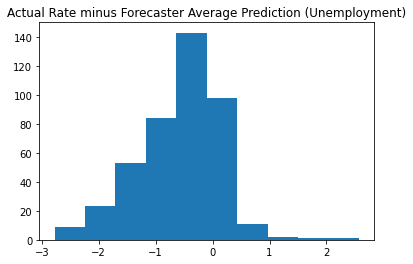

In [47]:
run_model(unemp, "Unemployment", "RF", plot = True)

### Real GDP

Differences in actual vs. model prediction (Real GDP)
Mean: -0.019887998352030686
Median: 0.007806775000000599
Max: 6.664692999999996
Min: -6.395879000000002
Correlation Coef: 0.7926640964520639
RMSE: 0.8579286333496776


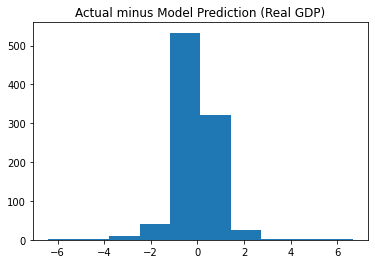

Differences in actual vs. forecaster average prediction (Real GDP)
Mean: -0.08586768484093114
Median: -0.0319799999999999
Max: 4.50324
Min: -5.28676
Correlation Coef: 0.7926640964520639
RMSE: 1.265242622422076


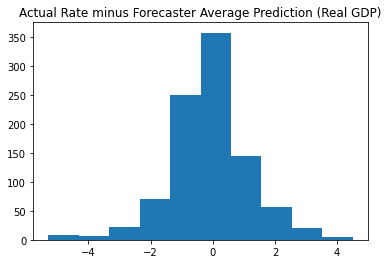

In [54]:
run_model(rgdp, "Real GDP", "RF", plot=True)

### Core CPE

Differences in actual vs. model prediction (Core PCE)
Mean: 0.004422418135023902
Median: -0.018962610937437452
Max: 0.9702439637295288
Min: -0.6444154668228723
Correlation Coef: 0.6997189419050025
RMSE: 0.23815232215377494


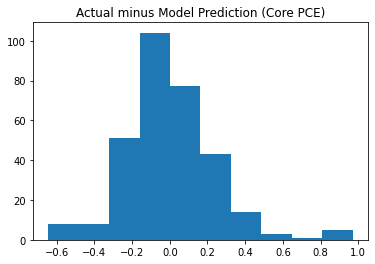

Differences in actual vs. forecaster average prediction (Core PCE)
Mean: -0.15240896755493497
Median: -0.1446502969286898
Max: 1.27903905586508
Min: -1.77096094413492
Correlation Coef: 0.6997189419050025
RMSE: 0.5025165611443665


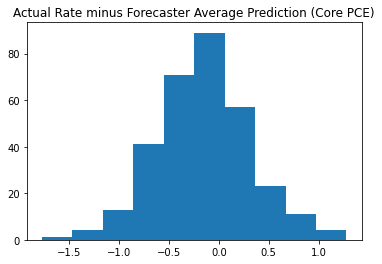

In [55]:
run_model(cpce, "Core PCE", "RF", plot=True)

### Core CPI

Differences in actual vs. model prediction (Core CPI)
Mean: 0.029939810516876116
Median: 0.008436147381071013
Max: 1.3959413127575186
Min: -1.3739080256529057
Correlation Coef: 0.7517625812170226
RMSE: 0.28038031911345607


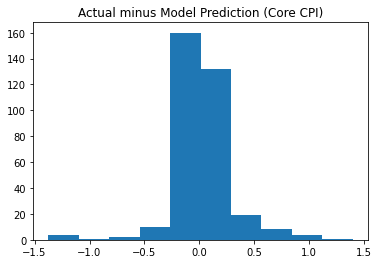

Differences in actual vs. forecaster average prediction (Core CPI)
Mean: -0.10278482426832596
Median: -0.07685321123389
Max: 2.12432412557292
Min: -1.6044274735366661
Correlation Coef: 0.7517625812170226
RMSE: 0.5144691869265156


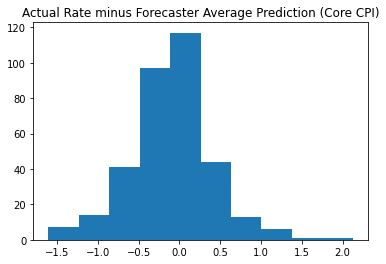

In [56]:
run_model(ccpi, "Core CPI", "RF", plot=True)

### Nominal GNP

Differences in actual vs. model prediction (Nominal GNP)
Mean: 0.20005717553260097
Median: 0.0
Max: 4.134821100000005
Min: -3.812794999999987
Correlation Coef: 0.8451572436623113
RMSE: 1.08630635082444


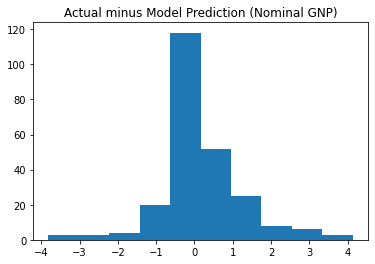

Differences in actual vs. forecaster average prediction (Nominal GNP)
Mean: 1.2891605081417234
Median: 0.9676
Max: 8.19474
Min: -4.61285
Correlation Coef: 0.8451572436623113
RMSE: 2.3098255089749813


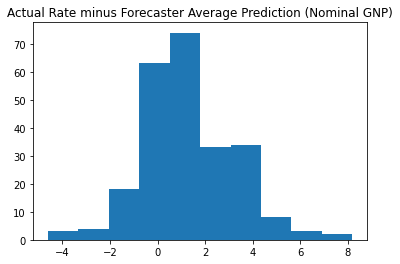

In [57]:
run_model(ngnp, "Nominal GNP", "RF", plot=True)

### Real GNP

Differences in actual vs. model prediction (Real GNP)
Mean: -0.0603284265383902
Median: 0.030340799999992285
Max: 3.162485100000001
Min: -7.73518713333333
Correlation Coef: 0.8768346118172566
RMSE: 1.149553922942384


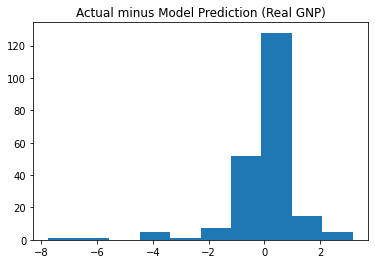

Differences in actual vs. forecaster average prediction (Real GNP)
Mean: 0.7175402790697674
Median: 0.8447200000000001
Max: 6.3064100000000005
Min: -4.73796
Correlation Coef: 0.8768346118172566
RMSE: 1.7114705666680812


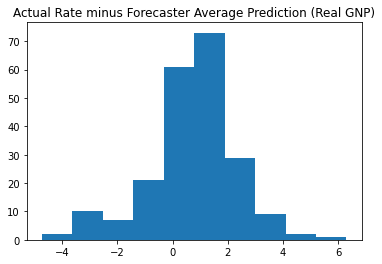

In [58]:
run_model(rgnp, "Real GNP", "RF", plot=True)

## Random Forest Evaluation

In [59]:
evaluate("RF")

We decrease RMSE by 0.47468965040937067
We increase R-squared by 0.25696902986047504
